# LCPB 21-22 exercise 2: *Deep Neural Network (DNN)*

#### TASKS

1. Study the performance of the DNN when the number N of samples is
a) reduced
b) increased
c) augmented
Point 1.c means taking the given N=4000 samples, split them in training and validation, and
“augment” the training samples by generating artificial ones that are similar to the real samples. For
instance, a given sample x=(x1,x2) can be transformed to multiple copies (x1+s1, x2+s2) where
each (s1,s2) is a small random shift.
2. Implement a “grid search” as shown in NB11 to improve one or more of the aspects or
parameters of the model. Possible tests include: different activation units (sigmoid, relu, elu,
etc.), different minimization algorithms (ADAM, RMSprop, Nesterov, etc.), different
dropouts, different size or number of layers, etc.

##### *OPTIONAL*

3. Check if any other rescaling of data or initialization of weights may improve the accuracy of the
DNN.
4. Study different data, for instance generated by the second nonlinear function or other choices.

In [26]:
# importing cell
import numpy as np
import matplotlib.pyplot as plt
# DNN stuff
from keras.models import Sequential
from keras.layers import Dense, Dropout


# random seed for reproducibility
np.random.seed(12345)

## Data generation


In [27]:
# defining non linear function to interpolate

def f(x,c=1):
    r=0
    if c==1:
        if x[0]>-20 and x[1]>-40 and x[0]+x[1] < 40:
            r=1
    if c==2:
        if (np.sign(x.sum())*np.sign(x[0]))*np.cos(np.linalg.norm(x)/(2*np.pi))>0:
            r=1
    return r


def filename(s,TYPE=1):
    return "./DATA/"+s+"-for-DNN-"+str(TYPE)+".dat"


mkdir: DATA: File exists
2 5 1


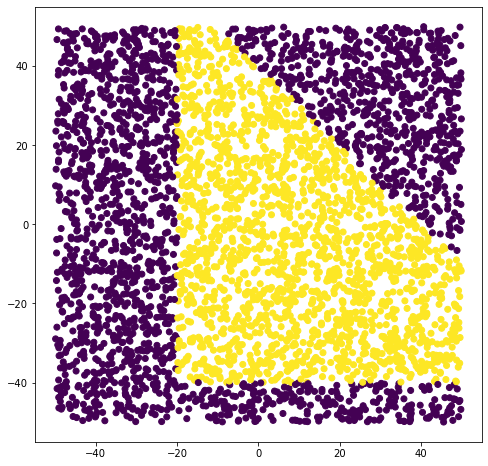

In [28]:
# number of data
N=4000
# N=10000
# size of each sample
L=2
# box size
B=100

!mkdir DATA

TYPE=1

print(np.random.randint(0,10),np.random.randint(0,10),np.random.randint(0,10))

x,y = (np.random.random((N,2))-0.5)*B, np.zeros(N)
for i in range(N):
    # label data according to a nonlinear function "f"
    y[i] = f(x[i],TYPE)
        
plt.figure(figsize = (8,8))
plt.scatter(x[:,0],x[:,1],c=y)
plt.show

np.savetxt(filename("data",TYPE),x)
np.savetxt(filename("labels",TYPE),y,fmt="%d")

## Training


2
[-31.60811883 -29.54397214] 0.0
[6.77250291 9.5544703 ] 1.0
[46.45145197 15.31770969] 0.0
[24.89066375 15.35698709] 0.0
[24.77148093 46.13067361] 0.0
[-49.16117021 -39.35556233] 0.0
[-20.12962862  15.64111831] 0.0
[30.98125525 37.21759137] 0.0
[46.46475974 22.36853469] 0.0
[14.24753279 21.74536208] 1.0
data: 4000
train: 3200


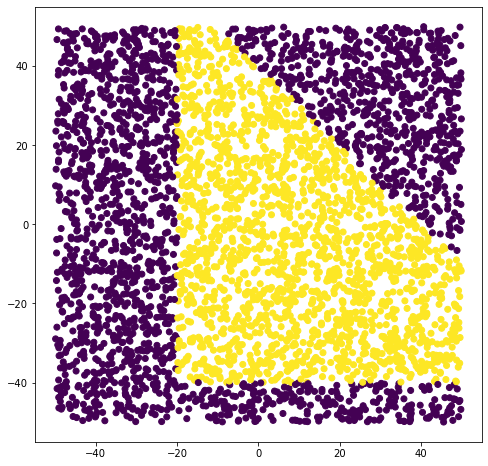

In [29]:
perc_train = 0.8

# Keras works with numpy arrays: just use them from the start
TYPE=1
x = np.loadtxt(filename("data",TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",TYPE), delimiter=' ')
N = len(x)

# dim. of a sample
L = len(x[0])
print(L)

for i in range(10):
    print(x[i],y[i])

N_train = int(perc_train * N)
print(f'data: {N}\ntrain: {N_train}')

plt.figure(figsize = (8,8))
plt.scatter(x[:,0],x[:,1],c=y)
plt.show;


In [30]:
# Train Test split
(x_train, y_train) = (x[0:N_train],y[0:N_train])
(x_valid, y_valid) = (x[N_train:],y[N_train:])
print("Train:",len(x_train),"\t Validation:",len(x_valid))

Train: 3200 	 Validation: 800


In [31]:
# Rescaling
def Rescale(x):
    # return (x-x.mean())/np.sqrt(x.var()), np.sqrt(x.var())
    return x/50

x_train = Rescale(x_train)
x_valid = Rescale(x_valid)

In [32]:
# Definition of several types of models

CASE=1

if CASE==1:
    model = Sequential()
    model.add(Dense(L,input_shape=(L,),activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation='sigmoid'))
    nepoch=400
if CASE==2:
    model = Sequential()
    model.add(Dense(L,input_shape=(L,),activation='sigmoid'))
    model.add(Dense(3,activation='sigmoid'))
    model.add(Dense(1,activation='sigmoid'))
    nepoch=400
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 2)                 6         
                                                                 
 dense_5 (Dense)             (None, 20)                60        
                                                                 
 dense_6 (Dense)             (None, 20)                420       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 21        
                                                                 
Total params: 507
Trainable params: 507
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
# compile it with a given loss function and optimizer algorithm
model.compile(loss='binary_crossentropy',
              #optimizer='RMSprop',
              optimizer='adam',
              metrics=['accuracy'])

In [34]:
# TRAINING
fit = model.fit(x_train, y_train,
               epochs = nepoch, batch_size = 50,
               validation_data=(x_valid,y_valid),
               verbose=0)

2022-03-18 18:38:09.488818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-18 18:38:09.846055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Okay so we have trained our model; now we look at the loss progression during training, both on training and validation sets.

In [35]:
# the .fit() method of the Keras Model class returns a history object,
# whose attribute History.history is basically a dictionary:
fit.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

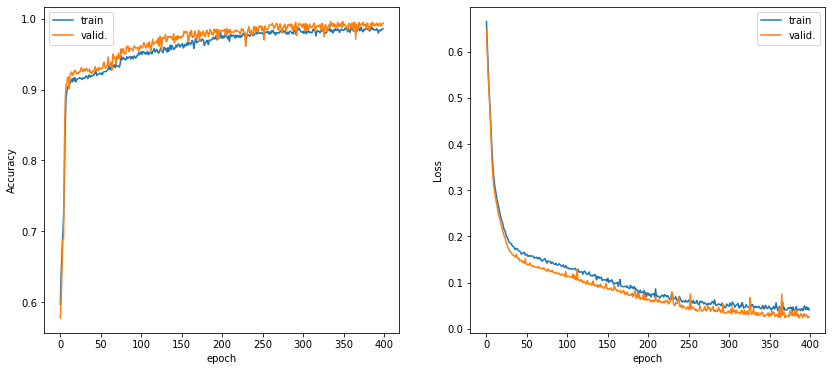

In [36]:
fig,axs=plt.subplots(1,2,figsize=(14,6.))
axs[0].plot(fit.history['accuracy'],label="train")
axs[0].plot(fit.history['val_accuracy'],label="valid.")
axs[0].set_xlabel('epoch')
axs[0].set_ylabel("Accuracy")

axs[1].plot(fit.history['loss'],label="train")
axs[1].plot(fit.history['val_loss'],label="valid.")
axs[1].set_xlabel('epoch')
axs[1].set_ylabel("Loss")
for ax in axs: ax.legend()

In [37]:
dX = 2
X1 = np.arange(-50,50+dX, dX)
LG = len(X1)
grid = np.zeros((LG*LG,2))
k=0
for i in range(LG):
    for j in range(LG):
        grid[k,:]=(X1[j],X1[i])
        k=k+1
print(len(X1),len(grid))
print(grid[-1])

# RESCALE

grid_r = grid/50

pred = model.predict(grid_r)

51 2601
[50. 50.]


2022-03-18 18:39:46.655431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


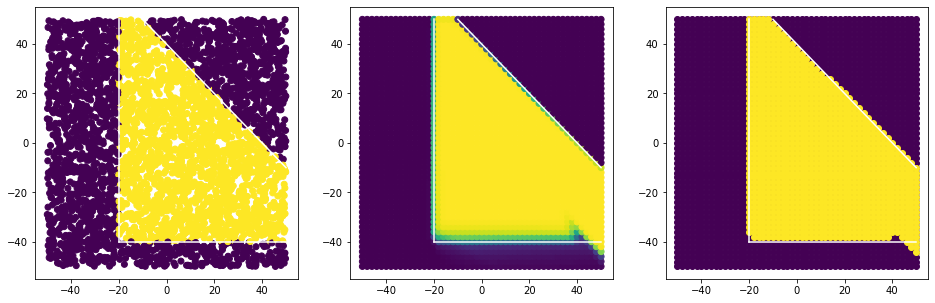

In [38]:
def boundaries():    
    # function to plot white lines corresponding to the boundaries
    ax.plot((-20,-20),(-40,50),c="w")
    ax.plot((-20,50),(-40,-40),c="w")
    ax.plot((-10,50),(50,-10),c="w")
fig,AX=plt.subplots(1,3,figsize=(16,5.))
ax=AX[0]
ax.scatter(x[:,0],x[:,1],c=y) # original data
boundaries()
ax=AX[1]
ax.scatter(grid[:,0],grid[:,1],c=pred) # predicted data
boundaries()
ax=AX[2]
W1=np.where(pred>0.5)[0] 
ax.scatter(grid[:,0],grid[:,1],c="#440154")
ax.scatter(grid[W1,0],grid[W1,1],c="#fde725")
boundaries()
plt.show
plt.show;

In [39]:
#testing w new data


#generating the data for the second (reduced) dataset
N=3000
x,y = (np.random.random((N,2))-0.5)*B, np.zeros(N)
for i in range(N):
    # label data according to a nonlinear function "f"
    y[i] = f(x[i],TYPE)
#let`s generate the file to store the second dataset and its labels
np.savetxt(filename("data_reduced",TYPE),x)
np.savetxt(filename("labels_reduced",TYPE),y,fmt="%d")


#generating the data for the third (increased) dataset
N=8000
x,y = (np.random.random((N,2))-0.5)*B, np.zeros(N)
for i in range(N):
    # label data according to a nonlinear function "f"
    y[i] = f(x[i],TYPE)
#let`s generate the file to store the third dataset (increased) and its labels
np.savetxt(filename("data_increased",TYPE),x)
np.savetxt(filename("labels_increased",TYPE),y,fmt="%d")


#generating the data for the forth (augmented) dataset
N=4000
x,y = (np.random.random((N,2))-0.5)*B+np.random.random((N,2)), np.zeros(N)
for i in range(N):
    # label data according to a nonlinear function "f"
    y[i] = f(x[i],TYPE)

#let`s generate the file to store the forth dataset (augmented) and its labels
np.savetxt(filename("data_augmented",TYPE),x)
np.savetxt(filename("labels_augmented",TYPE),y,fmt="%d")

In [48]:
#Now let's built two options for neural networks (two different kinds of architectures)

#reproducibility
np.random.seed(204048)

#Let's set a function to divide data from a specific file in training and test set
def split_data(filename_for_data, filename_for_label, k=0.8):
    x = np.loadtxt(filename(filename_for_data,TYPE),delimiter=' ')
    y = np.loadtxt(filename(filename_for_label,TYPE),delimiter=' ')
    N=len(x)
    k=0.8
    N_train = int(k*N)
    # train validation split
    (x_train, y_train) = (x[0:N_train],y[0:N_train])
    (x_valid, y_valid) = (x[N_train:],y[N_train:])
    # rescaling
    def Rescale(x):
        return (x-x.mean())/np.sqrt(x.var())

    x_train = Rescale(x_train)
    x_valid = Rescale(x_valid)
    return x, y, x_train, x_valid, y_train, y_valid


def train_and_plot(filename_for_data, filename_for_labels, k=0.8, epoch=400):
    x,y, x_train, x_valid, y_train, y_valid = split_data(filename_for_data,filename_for_labels)
    nepoch=epoch
    for CASE in range(1,3):
        print(CASE)
        if CASE==1:
            model1 = Sequential()
            model1.add(Dense(L,input_shape=(L,),activation='relu')) #input layer
            model1.add(Dense(20,activation='relu')) #first layer
            model1.add(Dense(20,activation='relu')) #second layer
            model1.add(Dense(1,activation='sigmoid')) # final output    
            
            model1.compile(loss='binary_crossentropy',
                            optimizer='adam',
                            metrics=['accuracy'])
            history1=model1.fit(x_train,y_train, epochs=nepoch,batch_size = 50,
                validation_data=(x_valid,y_valid),verbose=0)
            y_pred1 = model1.predict(grid_r)
            
            
            fig,AX=plt.subplots(1,3,figsize=(16,5.))
            fig.suptitle("CASE 1")
            ax=AX[0]
            ax.scatter(x[:,0],x[:,1],c=y) # original data
            boundaries()
            ax=AX[1]
            ax.scatter(grid[:,0],grid[:,1],c=pred) # predicted data
            boundaries()
            ax=AX[2]
            W1=np.where(pred>0.5)[0] 
            ax.scatter(grid[:,0],grid[:,1],c="#440154")
            ax.scatter(grid[W1,0],grid[W1,1],c="#fde725")
            boundaries()
            plt.show;
            
        if CASE==2:
            model2 = Sequential()
            model2.add(Dense(L,input_shape=(L,),activation='sigmoid')) #input layer
            model2.add(Dense(3,activation='sigmoid'))
            model2.add(Dense(1,activation='sigmoid'))

            model2.compile(loss='binary_crossentropy',
                            optimizer='adam',
                            metrics=['accuracy'])
            history2=model2.fit(x_train,y_train, epochs=nepoch,batch_size = 50,
                validation_data=(x_valid,y_valid),verbose=0)
            y_pred2 = model2.predict(grid_r)

            
            fig,AX=plt.subplots(1,3,figsize=(16,5.))
            fig.suptitle("CASE 2")
            ax=AX[0]
            ax.scatter(x[:,0],x[:,1],c=y) # original data
            boundaries()
            ax=AX[1]
            ax.scatter(grid[:,0],grid[:,1],c=pred) # predicted data
            boundaries()
            ax=AX[2]
            W1=np.where(pred>0.5)[0] 
            ax.scatter(grid[:,0],grid[:,1],c="#440154")
            ax.scatter(grid[W1,0],grid[W1,1],c="#fde725")
            boundaries()
            plt.show;
            
    return model1, model2, history1, history2, x_valid, y_valid




In [49]:
def analysis(model, history, X_test, Y_test, title):
    score = model.evaluate(X_test, Y_test, verbose=0)

    # print performance
    print()
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    # look into training history

    # summarize history for accuracy
    
    fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(14,6))
    fig.suptitle(title)
    ax_1.plot(history.history['accuracy'])
    ax_1.plot(history.history['val_accuracy'])
    ax_1.set(ylabel='model accuracy', xlabel='epoch')
    ax_1.legend(['train', 'test'], loc='best')

    # summarize history for loss
    ax_2.plot(history.history['loss'])
    ax_2.plot(history.history['val_loss'])
    ax_2.set(ylabel='model loss', xlabel='epoch')
    plt.legend(['train', 'test'], loc='best')

    

1


2022-03-18 19:17:29.838269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-18 19:17:30.152362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-18 19:18:39.557680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2


2022-03-18 19:18:39.849183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-18 19:18:40.156102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-18 19:19:43.400805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-18 19:19:43.580482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Test loss: 0.09701061248779297
Test accuracy: 0.9650000333786011

Test loss: 0.254699170589447
Test accuracy: 0.9133333563804626


2022-03-18 19:19:43.759636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


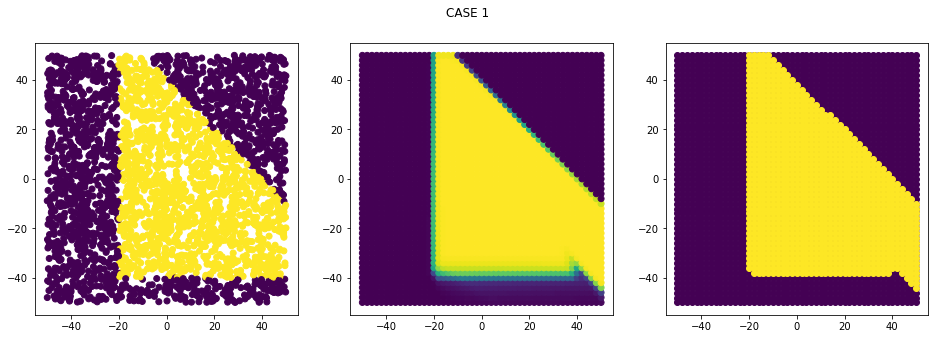

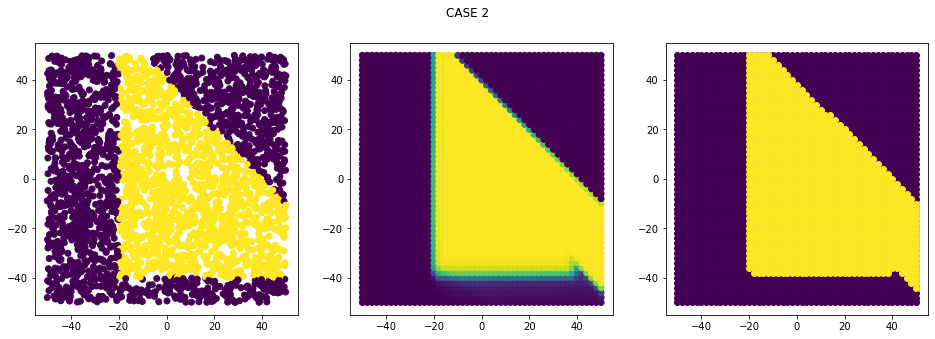

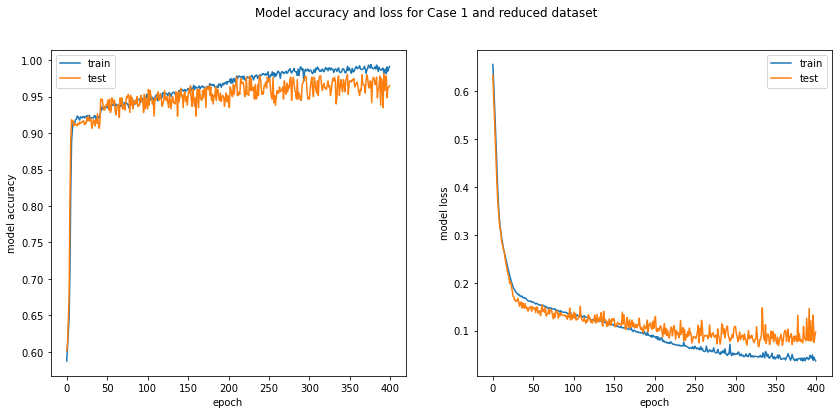

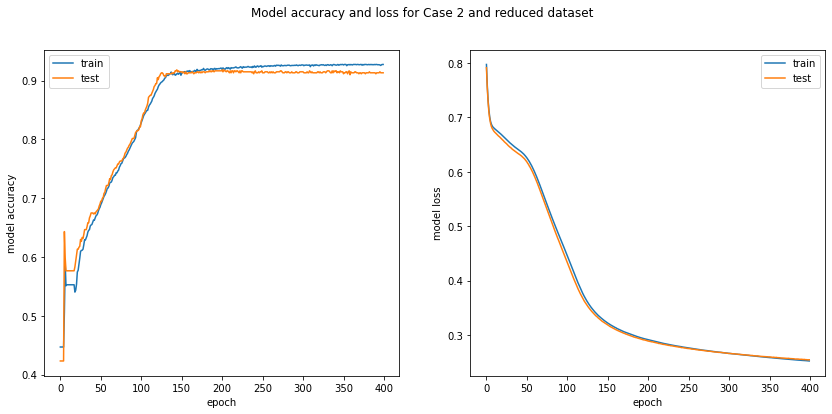

In [47]:
model1, model2, history1, history2, X_test, Y_test = train_and_plot("data_reduced", "labels_reduced", k=0.8)
title1="Model accuracy and loss for Case 1 and reduced dataset "
title2="Model accuracy and loss for Case 2 and reduced dataset"
analysis(model1, history1, X_test, Y_test, title1)
analysis(model2, history2,  X_test, Y_test, title2)

1


2022-03-18 19:20:30.010716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-18 19:20:30.545875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-18 19:23:22.773119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2


2022-03-18 19:23:23.064381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-18 19:23:23.582897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-18 19:26:06.912127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-18 19:26:07.100611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Test loss: 0.3832761347293854
Test accuracy: 0.8100000023841858


2022-03-18 19:26:07.342423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Test loss: 0.18111346662044525
Test accuracy: 0.9356249570846558


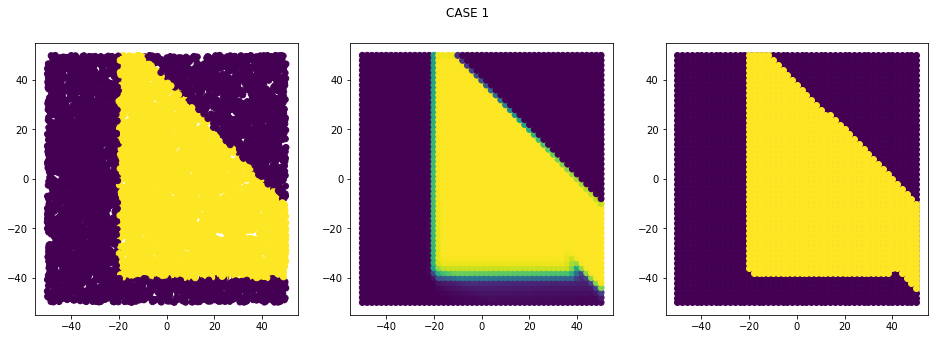

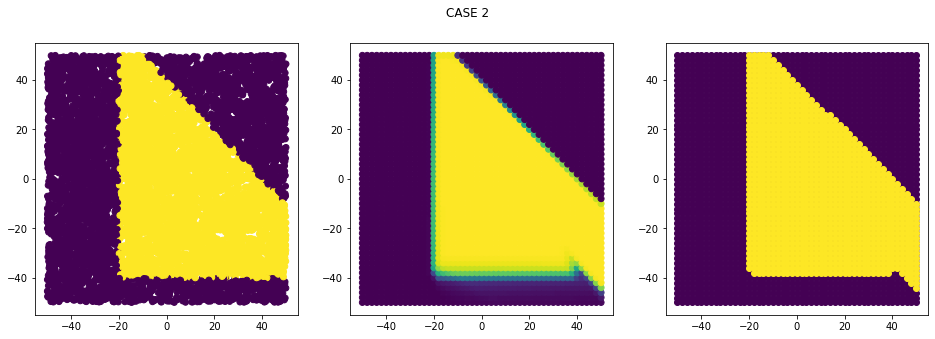

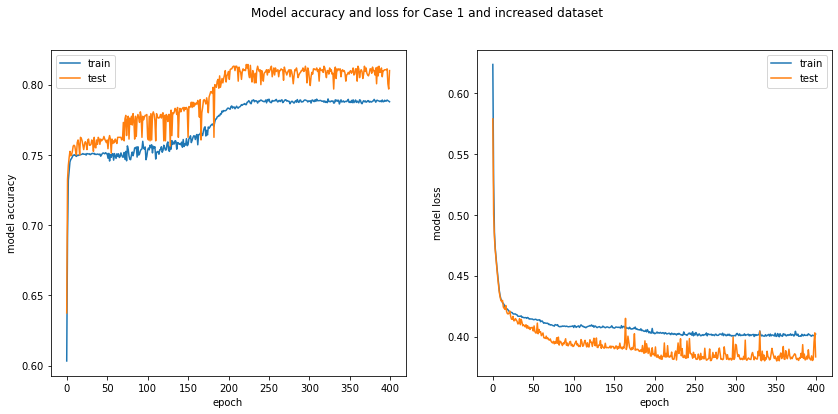

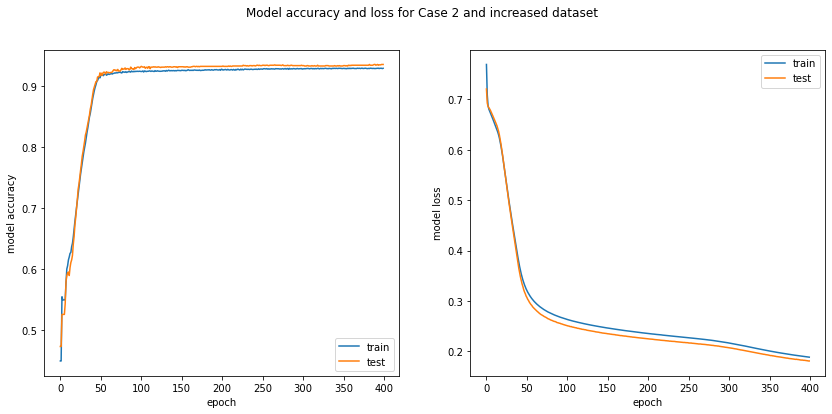

In [50]:
model1, model2, history1, history2, X_test, Y_test = train_and_plot("data_increased", "labels_increased", k=0.8)
title1="Model accuracy and loss for Case 1 and increased dataset "
title2="Model accuracy and loss for Case 2 and increased dataset"
analysis(model1, history1, X_test, Y_test, title1)
analysis(model2, history2,  X_test, Y_test, title2)

1


2022-03-18 19:26:08.305289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-18 19:26:08.733941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-18 19:27:45.838817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2


2022-03-18 19:27:46.374883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-18 19:27:46.701182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-18 19:29:10.495858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-18 19:29:10.670241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Test loss: 0.05823442339897156
Test accuracy: 0.9862499833106995

Test loss: 0.2462105005979538
Test accuracy: 0.9149999618530273


2022-03-18 19:29:10.832120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


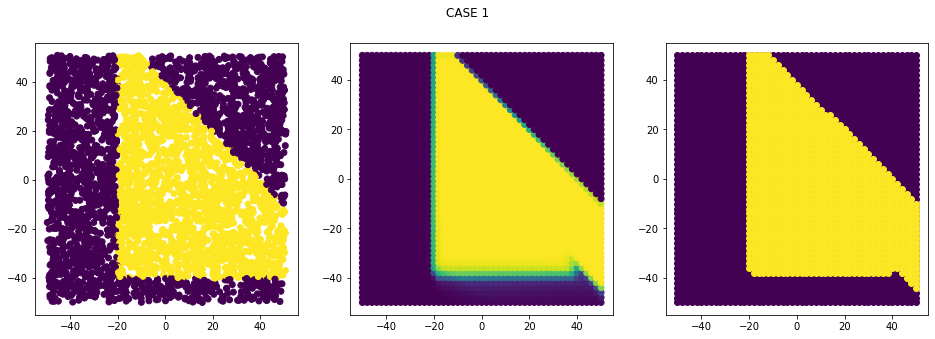

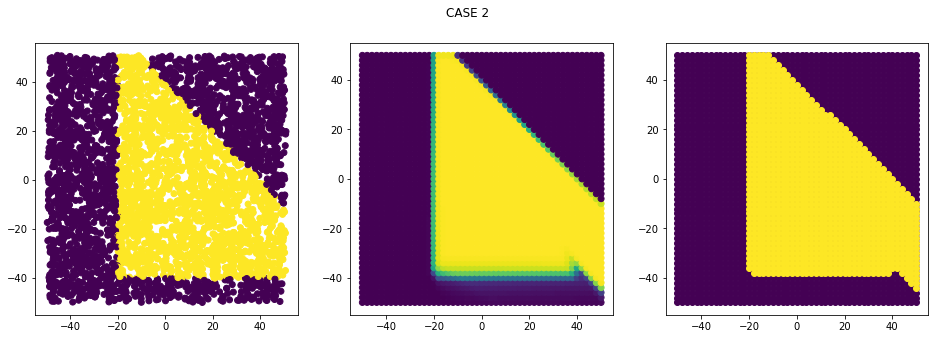

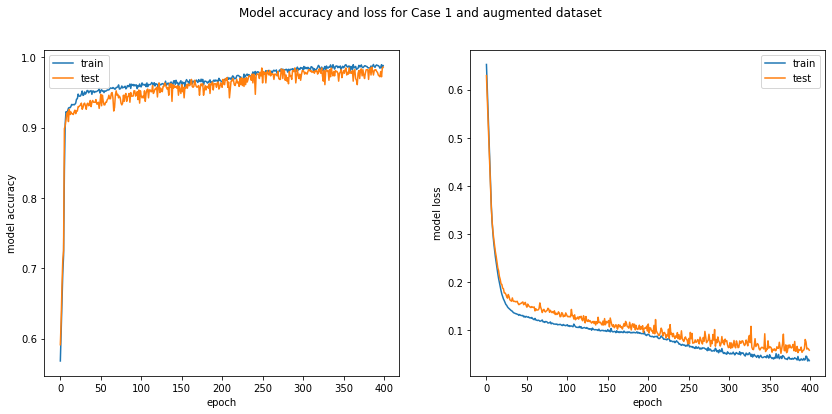

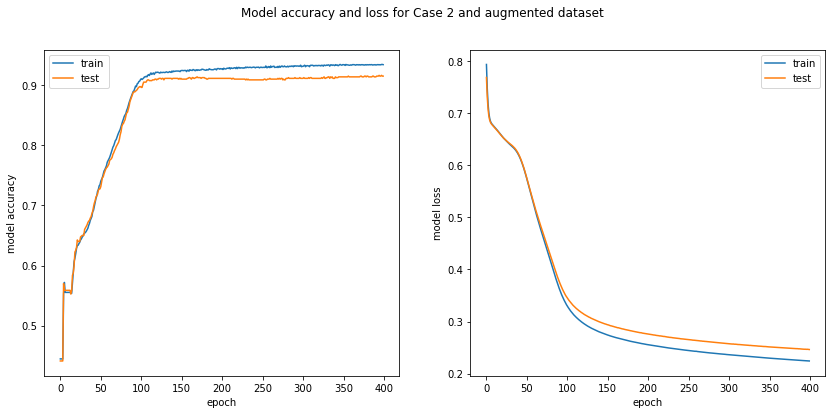

In [51]:
model1, model2, history1, history2, X_test, Y_test = train_and_plot("data(augmented)", "labels(augmented)", k=0.8)
title1="Model accuracy and loss for Case 1 and augmented dataset "
title2="Model accuracy and loss for Case 2 and augmented dataset"
analysis(model1, history1, X_test, Y_test, title1)
analysis(model2, history2,  X_test, Y_test, title2)

In [21]:
def build_DNN(layer_arch, act_arch,act_inout,dropout=False,dropout_rate=0.2):
    """
    Function to build a Keras Sequential NN model with a given architecture and activation functions. 
    First layer is already defined to have 2 neurons (x and y) and output layers is already defined to have one output (z)
    Args:

    layer_arch : tuple, list, or iterable of integers that define each hidden layer
    act_arch : tuple, list, or iterable of string defining the activation function for each hidden layer. Must be the same size as layer_arch
    act_inout : touple or list of two string elements, defining the activation function of the input layer and the output layer.
    dropout : bool (default False); if True adds a Dropout layer between the last hidden layer and the output layer.
    """
    if len(layer_arch != len(act_arch)):
        raise Exception('Unmatched activation and layer architecture sizes!')

    model = Sequential()
    model.add(Dense(L,input_shape=(L,),activation=act_inout[0])) # input layer

    for n_neurons,act in zip(layer_arch,act_arch):
        model.add(Dense(n_neurons,activation=act))

    if dropout:
        model.add(Dropout(dropout_rate))
        
    model.add(Dense(1,activation='sigmoid')) # output layer
    
    return model

In [22]:
architectures = [
    (10,10),
    (20,),
    (5,5)
]

activations = [
    ('relu','relu'),
    ('sigmoid',),
    ('relu','sigmoid')
]

act_inouts = [
    ('sigmoid','sigmoid'),
    ('relu','sigmoid'),
    ('relu','relu')
]

dropouts = [
    True,
    True,
    True
]

dropout_rates = [
    0.2,
    0.2,
    0.2
]

In [23]:
for arch,acts,act_io,drop,droprate in zip(architectures,activations,act_inouts,dropouts,dropout_rates):
    model = build_DNN(arch,acts,act_io,drop,droprate)
    

TypeError: object of type 'bool' has no len()